# KIỂM TRA GIỮA KỲ - Image Classification
##THÔNG TIN SINH VIÊN:

#Bài toán phân loại phương tiện giao thông

Tổng quan: Thực hiên các bước để xây dựng một hệ thống học máy cho bài toán phân loại phương tiện giao thông: khảo sát dữ liệu, trích xuất đặc trưng, xây dựng mô hình phân loại, phân loại trên hình ảnh thực tế. Yêu cầu các kiến thức về lập trình Python với các thư viện: OpenCV, scikit-learn, pickle, numpy.

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
import sklearn

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

## Câu hỏi 1: Khảo sát tập dữ liệu
Thư mục trainingset bao gồm 5 thư mục con ứng với 5 nhãn của bài toán, trong mỗi thư mục con chứa ảnh tương ứng với nhãn.
### Câu hỏi 1.1: Quan sát một vài mẫu dữ liệu
Viết hàm load_image() nhận đầu vào là đường dẫn ảnh, trả về mảng numpy lưu trữ ảnh, sử dụng thư viện OpenCV.

In [ ]:
def load_image(image_path):
    #### YOUR CODE HERE ####
    return cv2.imread(image_path)
    #### END YOUR CODE #####

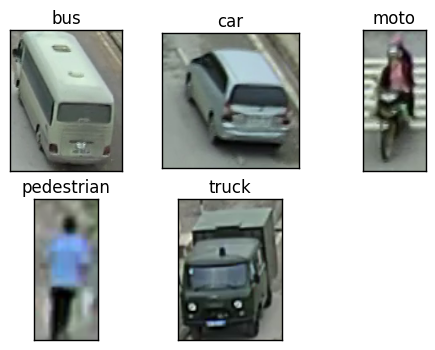

In [ ]:
samples_list = []
samples_label = []
for label in os.listdir('trainingset'):
    sample_file = os.listdir(os.path.join('trainingset', label))[0]

    samples_list.append(load_image(os.path.join('trainingset', label, sample_file)))

    samples_label.append(label)

for i in range(len(samples_list)):
    plt.subplot(2, 3, i + 1), plt.imshow(cv2.cvtColor(samples_list[i], cv2.COLOR_BGR2RGB))
    plt.title(samples_label[i]), plt.xticks([]), plt.yticks([])

plt.show()

Một vài hàm hay sử dụng trong thư viện os:
- Hàm os.listdir(path): Trả về một list chứa tên các thư mục và file nằm trong thư mục path. Vì hàm trả về một list nên ta có thể tính được tổng số folder và file trong một thư mục (dùng hàm len())
- Hàm os.path.join(t1, t2, [t3, ...]): Trả về đường dẫn trong hệ điều hành tương ứng nối các đường dẫn t1, t2, t3,... Ví dụ ta có t1 = 'trainingset', t2 = 'image' thì hàm trả về xâu s = 'trainingset/image' với Ubuntu hoặc s = 'trainingset\\image' với Windows.

### Câu hỏi 1.2: Thống kê dữ liệu
Hãy viết hàm statistic() để thống kê số lượng ảnh ứng với mỗi nhãn. Hàm statistic() cần trả về 2 danh sách (list): label, num_images. Danh sách label lưu tên các nhãn và danh sách num_images lưu số lượng ảnh tương ứng với nhãn lưu ở danh sách label.

In [ ]:
def statistic():
    label = []
    num_images = []

    ########################
    #### YOUR CODE HERE ####
    trainingset_path = "trainingset"  # Đường dẫn đến thư mục tập dữ liệu

    for folder in os.listdir(trainingset_path):  # Duyệt qua các thư mục con
        folder_path = os.path.join(trainingset_path, folder)
        if os.path.isdir(folder_path):  # Kiểm tra nếu đó là thư mục
            label.append(folder)  # Lưu tên nhãn
            num_images.append(len(os.listdir(folder_path)))  # Đếm số lượng ảnh trong thư mục
    ########################

    return label, num_images

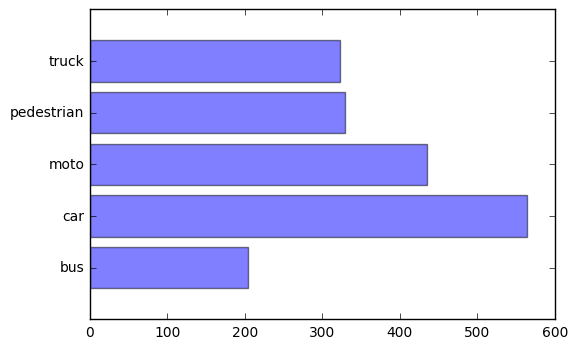

Total images: 1855


In [ ]:
label, num_images = statistic()

y_pos = np.arange(len(label))

plt.barh(y_pos, num_images, align='center', alpha=0.5)
plt.yticks(y_pos, label)
plt.show()

print('Total images: %d' %(sum(num_images)))

### Câu hỏi 1.3: Xây dựng danh sách chứa ảnh

Xây dựng một list lưu trữ ảnh và nhãn tương ứng của nó. Hãy Viết hàm read_data(), hàm này trả về hai list X, Y, trong đó mỗi phần tử của list X lưu trữ một mảng numpy biểu diễn một ảnh và mỗi phần tử của list Y lưu trữ nhãn (dưới dạng số nguyên) tương ứng của ảnh.

In [ ]:
def read_data(label2id):
    X = []
    Y = []

    for label in os.listdir('trainingset'):
        for img_file in os.listdir(os.path.join('trainingset', label)):
            ########################
            #### YOUR CODE HERE ####
            img_path = os.path.join('trainingset', label, img_file)
            img = cv2.imread(img_path)
            ########################
            X.append(img)
            Y.append(label2id[label])

    return X, Y

In [ ]:
# Label to id, used to convert string label to integer
label2id = {'pedestrian':0, 'moto':1, 'truck':2, 'car':3, 'bus':4}
X, Y = read_data(label2id)
print(len(X))
print(len(Y))
print(X[0].shape)
print(Y[0])

1855
1855
(168, 134, 3)
4


## Câu hỏi 2: Trích xuất đặc trưng (features extraction)

Thực hiện trích xuất đặc trưng SIFT (SIFT keypoints descriptor), xây dựng từ điển và mô hình Bag-of-Word (BoW). Bạn hãy lập trình hoàn chỉnh các hàm theo yêu cầu cụ thể dưới đây

### Câu hỏi 2.1: Trích xuất đặc trưng SIFT

Hãy viết hàm extract_sift_features() nhận đầu vào là list ảnh ta đã xây dựng được từ câu hỏi trước và trả về list image_descriptors, phần tử thứ p trong list image_descriptors lại là một list chứa các SIFT keypoints descriptor ứng với ảnh thứ p trong list X.

Gợi ý: Để khởi tạo đối tượng SIFT trong OpenCV ta sử dụng lệnh: sift = cv2.xfeatures2d.SIFT_create(). Đối tượng này có phương thức detectAndCompute trả về 2 outputs kp và des, kp là một list chứa các keypoints được detect bởi SIFT, des là một numpy array chứa len(kp) vectors 128 chiều. Chúng ta sẽ dùng các des này để phục vụ bài toán phân loại.

In [ ]:
def extract_sift_features(X):
    image_descriptors = []
    sift = cv2.AKAZE_create()

    for i in range(len(X)):
        kp, des = sift.detectAndCompute(X[i], None)
        if des is not None:
            ########################
            #### YOUR CODE HERE ####
            image_descriptors.append(des)  # Thêm descriptors vào danh sách
            ########################
        else:
            image_descriptors.append([np.zeros(61)])

    return image_descriptors

In [ ]:
#import pickle

image_descriptors = extract_sift_features(X)
#pickle.dump(image_descriptors, open('img_des.dump', 'wb'))
#image_descriptors = pickle.load(open('img_des.dump', 'rb'))
print(len(image_descriptors))
print(image_descriptors[0][1].shape)
for i in range(10):
    print('Image {} has {} descriptors'.format(i, len(image_descriptors[i])))

1855
(61,)
Image 0 has 17 descriptors
Image 1 has 32 descriptors
Image 2 has 13 descriptors
Image 3 has 2 descriptors
Image 4 has 1 descriptors
Image 5 has 1 descriptors
Image 6 has 52 descriptors
Image 7 has 1 descriptors
Image 8 has 2 descriptors
Image 9 has 52 descriptors


### Câu hỏi 2.2: Xây dựng từ điển
Sử dụng hàm kmeans_bow() dưới đây nhận đầu vào là một list gồm tất cả các descriptors của các ảnh trong tập X và số cụm num_clusters, sử dụng thuật toán KMeans trong scikit-learn phân cụm các vector descriptors này thành num_clusters cụm. Hàm trả về một danh sách center của các cụm. Vì thao tác này mất rất nhiều thời gian nên ta sẽ lưu danh sách trả về bởi hàm kmeans_bow() ra một file nhị phân (sử dụng thư viện pickle) để tiện sử dụng sau này.

Trước tiên ta sẽ xây dựng một list chứa tất cả các descriptors:

In [ ]:
all_descriptors = []
for descriptors in image_descriptors:
    if descriptors is not None:
        for des in descriptors:
            all_descriptors.append(des)
print('Total number of descriptors: %d' %(len(all_descriptors)))

Total number of descriptors: 37822


Đối tượng kmeans có phương thức fit, nhận vào các điểm dữ liệu (trong bài toán hiện tại của chúng ta là list all_descriptors) và tìm ra n_clusters vector là tâm của các cụm dữ liệu. Để lấy được các vector này ta sử dụng thuộc tính $cluster_centers_$  của đối tượng kmeans

In [ ]:
def kmeans_bow(all_descriptors, num_clusters):
    bow_dict = []

    kmeans = KMeans(n_clusters=num_clusters).fit(all_descriptors)
    bow_dict = kmeans.cluster_centers_

    return bow_dict

Lưu từ điển phục vụ cho việc sử dụng sau này:

In [ ]:
num_clusters = 15
if not os.path.isfile('bow_dictionary.pkl'):
    BoW = kmeans_bow(all_descriptors, num_clusters)
    pickle.dump(BoW, open('bow_dictionary.pkl', 'wb'))
else:
    BoW = pickle.load(open('bow_dictionary.pkl', 'rb'))

print(len(BoW))
print(type(BoW[0]))

15
<type 'numpy.ndarray'>


### Câu hỏi 2.3: Xây dựng vector đặc trưng với mô hình BoW

Sử dụng hàm create_features_bow() nhận đầu vào là list image_descriptors, list BoW và num_clusters ở trên, trả về list X_features, trong đó phần tử thứ p của X_vectors là vector đặc trưng theo mô hình BoW ứng với ảnh thứ p, tập keypoint descriptors thứ p. Hãy chú ý sự tương ứng các phần tử trong 4 danh sách: X, Y, image_descriptors, X_features.

In [ ]:
from scipy.spatial.distance import cdist

In [ ]:
def create_features_bow(image_descriptors, BoW, num_clusters):
    X_features = []

    for i in range(len(image_descriptors)):
        features = np.array([0] * num_clusters)

        if image_descriptors[i] is not None:
            distance = cdist(image_descriptors[i], BoW)
            argmin = np.argmin(distance, axis=1)

            for j in argmin:
                features[j] += 1

        X_features.append(features)

    return X_features

In [ ]:
X_features = create_features_bow(image_descriptors, BoW, num_clusters)
print(len(X_features))
print(X_features[0])
print(sum(X_features[0]))
print(image_descriptors[0].shape[0])

1855
[0 2 2 0 0 0 1 1 4 0 3 1 2 0 1]
17
17


## Câu hỏi 3: Xây dựng mô hình
Từ các câu hỏi trước chúng ta đã xây dựng được vector đặc trưng ứng với mỗi ảnh trong bộ dữ liệu. Ở câu hỏi này chúng ta sẽ xây dựng các mô hình phân loại SVM

In [ ]:
print(len(X_features))
print(len(Y))

1855
1855


Chia tập dữ liệu thành tập train/test sử dụng train_test_split của sklearn:

In [ ]:
from sklearn.model_selection import train_test_split

X_train = []
X_test = []
Y_train = []
Y_test = []

########################    
#### YOUR CODE HERE ####
X_train, X_test, Y_train, Y_test = train_test_split(X_features, Y, test_size=0.3, random_state=42)
########################

print(len(X_train))
print(len(X_test))

Khai báo đối tượng SVM:

In [ ]:
########################
#### YOUR CODE HERE ####
svm = SVC(kernel='linear')
########################

print(svm)

Huấn luyện, kiểm tra độ chính xác của mô hình tương tự như các bài học trước (sử dụng các hàm fit, predict, score,... của đối tượng svm)

Huấn luyện mô hình:

In [ ]:
########################
#### YOUR CODE HERE ####
svm.fit(X_train, Y_train)
########################

Tính độ chính xác trên tập dữ liệu huấn luyện:

In [ ]:
########################
#### YOUR CODE HERE ####
train_accuracy = svm.score(X_train, Y_train)
print('Training accuracy:', train_accuracy)
########################

Tính độ chính xác trên tập dữ liệu test:

In [ ]:
########################
#### YOUR CODE HERE ####
test_accuracy = svm.score(X_test, Y_test)
print('Test accuracy:', test_accuracy)
########################

## Câu hỏi 4: Dùng mô hình đã huấn luyện dự đoán hình ảnh thực tế

Dùng mô hình đã huấn luyện để đưa ra dự đoán về một hình ảnh thực tế. Thực hiện lần lượt các bước: đọc ảnh, trích xuất đặc trưng BoW của ảnh, dự đoán sử dụng mô hình đã huấn luyện.

__Bước 1__: Đọc ảnh ở đường dẫn image_test/car.png, lưu ảnh vào biến img

In [ ]:
img = None

########################
#### YOUR CODE HERE ####
img = cv2.imread('image_test/car.png')
########################

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

my_X = [img]

__Bước 2__: Trích xuất đặc trưng SIFT (lưu vào biến my_image_descriptors) và BoW (lưu vào biến my_X_features) từ my_X:

In [ ]:
my_image_descriptors = None
my_X_features = None

########################
#### YOUR CODE HERE ####
# Trích xuất đặc trưng SIFT
sift = cv2.AKAZE_create()  # Sử dụng AKAZE thay cho SIFT
kp, my_image_descriptors = sift.detectAndCompute(img, None)

# Tạo vector đặc trưng BoW
my_X_features = np.array([0] * len(BoW))

if my_image_descriptors is not None:
    distance = cdist(my_image_descriptors, BoW)
    argmin = np.argmin(distance, axis=1)
    for j in argmin:
        my_X_features[j] += 1
########################

print(len(my_image_descriptors))
print(my_X_features[0].shape)

__Bước 3:__ Sử dụng mô hình đã huấn luyện để dự đoán, kết quả dự đoán lưu vào biến my_y_pred

In [ ]:
y_pred = None

########################
#### YOUR CODE HERE ####
my_y_pred = svm.predict([my_X_features])
y_pred = my_y_pred[0]  # Lấy giá trị dự đoán cho ảnh
########################

print(y_pred)
print(label2id)
# Get your label name using label2id variable (define above)
for key, value in label2id.items():
    if value == y_pred[0]:
        print('Your prediction: ', key)

# Câu hỏi 5

1. Thử nghiệm thuật toán trích xuất đặc trưng BoW với số lượng từ trong từ điển khác nhau 10, 20, 50, 100, 200. Vẽ biểu đồ độ chính xác trên tập test ứng với từng trường hợp.

2. Sử dụng GridSearchCV của sklearn để tìm tham số tốt nhất cho mô hình SVM.

3. Thay SVM bằng các bộ phân loại: K-Nearest Neighbors, Random forest. So sánh các kết quả và đưa ra nhận xét.

In [ ]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pickle
import os

# Các số lượng cụm BoW cần thử nghiệm
num_clusters_list = [10, 20, 50, 100, 200]
accuracies = []

for num_clusters in num_clusters_list:
    print(f'Testing BoW with {num_clusters} clusters...')
    
    # Xây dựng BoW
    if not os.path.isfile(f'bow_dictionary_{num_clusters}.pkl'):
        BoW = kmeans_bow(all_descriptors, num_clusters)
        pickle.dump(BoW, open(f'bow_dictionary_{num_clusters}.pkl', 'wb'))
    else:
        BoW = pickle.load(open(f'bow_dictionary_{num_clusters}.pkl', 'rb'))
    
    # Tạo vector đặc trưng BoW
    X_features = create_features_bow(image_descriptors, BoW, num_clusters)
    
    # Chia tập dữ liệu
    X_train, X_test, Y_train, Y_test = train_test_split(X_features, Y, test_size=0.2, random_state=42)
    
    # Khởi tạo và huấn luyện mô hình SVM
    svm = SVC(kernel='linear')
    svm.fit(X_train, Y_train)
    
    # Dự đoán và tính độ chính xác trên tập test
    Y_pred = svm.predict(X_test)
    acc = accuracy_score(Y_test, Y_pred)
    accuracies.append(acc)
    print(f'Accuracy for {num_clusters} clusters: {acc}')

# Vẽ biểu đồ
plt.plot(num_clusters_list, accuracies, marker='o', linestyle='-')
plt.xlabel('Number of Clusters')
plt.ylabel('Accuracy')
plt.title('BoW Accuracy on Test Set')
plt.grid()
plt.show()

In [ ]:
# Phần 2: GridSearchCV để tìm tham số tốt nhất cho mô hình SVM
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf']}
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2, cv=5)
grid.fit(X_train, Y_train)

print("Best parameters found: ", grid.best_params_)
print("Best accuracy: ", grid.best_score_)

In [ ]:
# Phần 3: Đánh giá mô hình tốt nhất trên tập test
best_svm = grid.best_estimator_
test_accuracy = best_svm.score(X_test, Y_test)
print("Test accuracy of best model: ", test_accuracy)